# Keras basic toolbox for image recognition

<div style="text-align:center">
	<figure class="image">
	  <img src="https://www.heise.de/imgs/18/2/5/0/3/0/6/8/transformation-31d49ea5fedf3443.jpeg" alt="{{ include.description }}" style="width: 500px">
	  <figcaption> B. de Smit and H.W. Lenstra Jr: Artful Mathematics. The
Heritage of M. C. Escher </figcaption>
	</figure>
</div>

## Introduction

The goal of this notebook is to develop a basic data pipeline that can be easily applied to new image recognition projects. Some concepts developed here:

- Use of generators for data loading using *flow_from_dataframe*.
- Triple splitting of the dataset (training, validation and test sets) for model training and evaluation.
- Usage of predefined CNN architectures.
- Evaluation of the model performance.

## Imports

In [4]:
import os

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib import image
import seaborn as sns

from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [5]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Block Numa warning

The [EuroSat Dataset](https://github.com/phelber/EuroSAT) contains images extracted from [Sentinel-2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) scenes that have been resampled to 10m resolution for all bands. The images are provided in two formats: *jpg* with three channels (RGB) and *tif* with the full set of Sentinel-2 bands. In this notebook I will work with the RGB dataset, so the first step will be to create the path to the data folder.

In [6]:
input_folder = "D:/Euro/Kaggle/"
dataset_folder = input_folder +  "EuroSAT/"

## Set dataframes

The dataset provides 3 dataframes linked to each of the sets that will be used to fit and evaluate the model: training, validation and test. Each of them contains the path and the label of each of the examples that conform the dataset. Let's load them into the memory.

In [7]:
column_names =  ["id", "path", "class_id", "class_name"]

training_df = pd.read_csv(dataset_folder + "train.csv", names=column_names)
validation_df = pd.read_csv(dataset_folder + "validation.csv", names=column_names)
test_df = pd.read_csv(dataset_folder + "test.csv", names=column_names)

In [8]:
training_df_size = len(training_df)
validation_df_size = len(validation_df)
test_df_size = len(test_df)

total_dataset_size = training_df_size + validation_df_size + test_df_size

print(f"Training set size: {training_df_size} ({round(training_df_size / total_dataset_size * 100)}%)")
print(f"Validation set size: {validation_df_size} ({round(validation_df_size / total_dataset_size * 100)}%)")
print(f"Test set size: {test_df_size} ({round(test_df_size / total_dataset_size * 100)}%)")

Training set size: 18901 (70%)
Validation set size: 5401 (20%)
Test set size: 2701 (10%)


## Configure generators

Although the images are not very large, the amount of them makes it reasonable to consider using a Tensorflow [Image Data Generator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) in order not to overload the memory. However, due to the size of the dataset and the experiments performed, I have come to the conclusion that using data augmentation is of little use, so I am going to dispense with that technique and simply rescale the pixels to the range 0, 1. The data has been previously normalized to the range 0, 255, so we can rescale it dividing by the maximum.

In [9]:
rescaling_factor = 1. / 255

training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

image_width = 64
image_height = 64

In [10]:
batch_size = 128

In [11]:
training_set = training_generator.flow_from_dataframe(
    dataframe=training_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

validation_set = test_generator.flow_from_dataframe(
    dataframe=validation_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle="true",
)

test_set = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 18900 validated image filenames belonging to 10 classes.
Found 5400 validated image filenames belonging to 10 classes.


C:\Users\RUET\miniconda3\envs\tf-ml3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(
C:\Users\RUET\miniconda3\envs\tf-ml3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 2700 validated image filenames belonging to 10 classes.


C:\Users\RUET\miniconda3\envs\tf-ml3\lib\site-packages\keras\preprocessing\image.py:1139: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


## Take a look at the data

Now that the generators have been set up, it is a good moment to have a look on the data. Let's start by the balance between classes.

In [12]:
class_name_list = np.array(list(training_set.class_indices.keys()))
labels, count = np.unique(training_set.classes, return_counts=True)

print(pd.Series(count, index=class_name_list))

AnnualCrop              2100
Forest                  2100
HerbaceousVegetation    2100
Highway                 1750
Industrial              1750
Pasture                 1400
PermanentCrop           1750
Residential             2100
River                   1750
SeaLake                 2100
dtype: int64


In [13]:
figure_height = 3
figure_width = 3
figure_size = (14, 14)

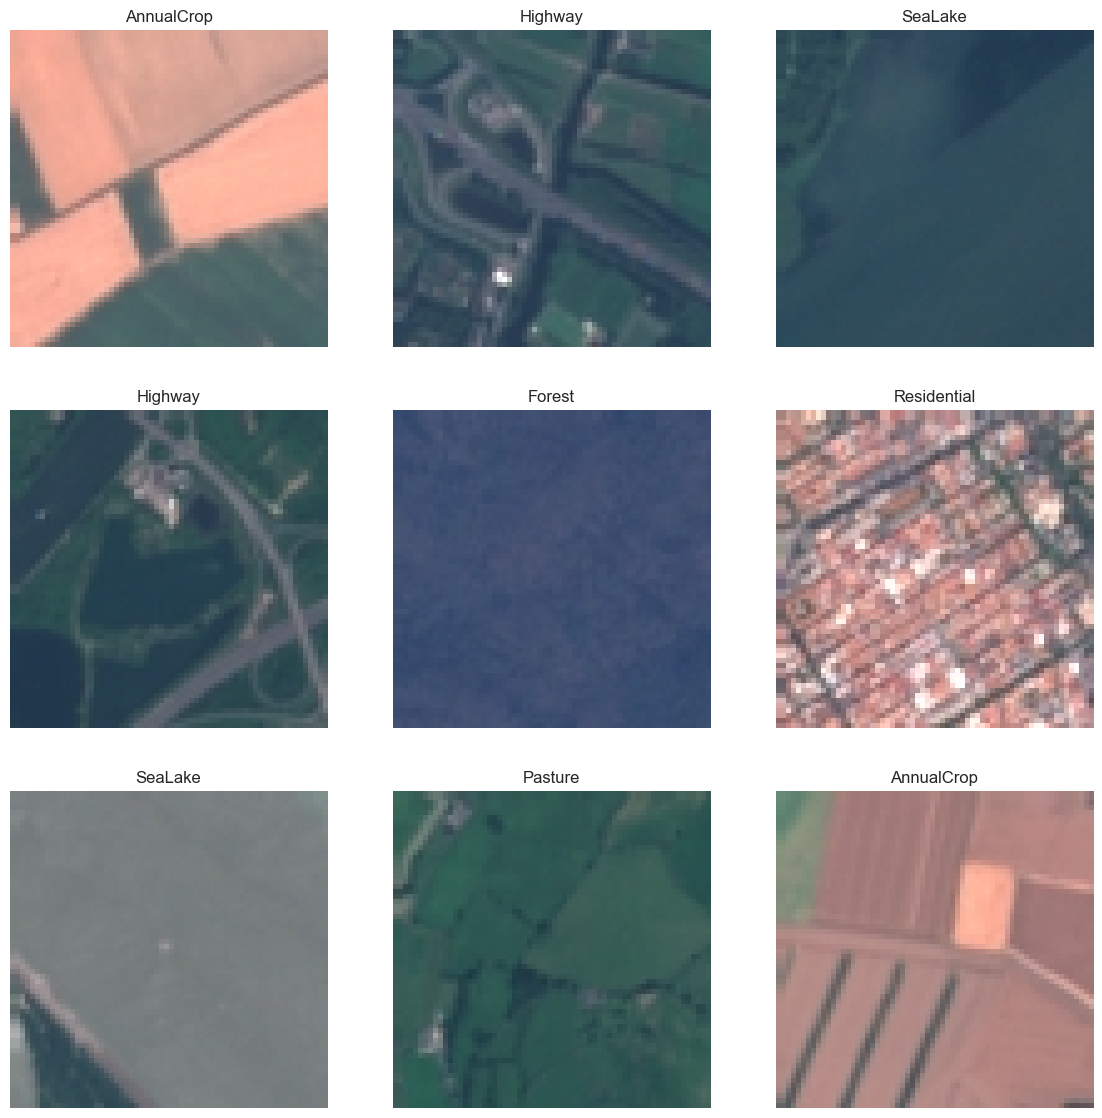

In [50]:
images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(images[index])
    plt.title(class_name_list[class_ids[index].astype(bool)][0])
    plt.axis("off")

plt.savefig("Samples.png", dpi=1000)

The good thing about satellite images is that, as long as we use the same sensor, the images are all taken from the same distance, which reduces the range of possibilities the model has to take into account. Between the image of a cat photographed from far away and one photographed very close up there is a huge difference. However, two images of crop fields taken using the sentinel-2 will always have a similar size.

It is also noticeable that images taken from above do not have a clear reference of what is up and what is down. We can find all kinds of orientations in the training set without a clear trend. 

On the other hand, the images [have been taken from a very small area of the world](https://www.researchgate.net/publication/319463676_EuroSAT_A_Novel_Dataset_and_Deep_Learning_Benchmark_for_Land_Use_and_Land_Cover_Classification) (Europe). All this added to the fact that there is a good number of examples of each class is what makes the use of traditional data augmentation techniques unnecessary in my opinion. However, the resulting model will only be generalizable to similar conditions. This might be addressed using more specific remote sensing data augmentation techniques.

## First model
## Load VGG16 architecture

In [33]:
def model_1(input_shape=(64, 64, 3), class_count=None):
    # Create the base VGG16 model
    base_model = VGG16(include_top=False, input_shape=input_shape)

    # Create a Sequential model
    model = Sequential()

    # Add the VGG16 base model
    model.add(base_model)

    # Flatten the output
    model.add(Flatten())

    # Add a Dropout layer
    model.add(Dropout(0.5))

    # Add a fully connected layer with 512 units and ReLU activation
    model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))

    # Add the output layer with softmax activation
    model.add(Dense(class_count, activation="softmax"))

    return model

In [35]:
# Assuming you have the class_count defined somewhere in your code
class_count = len(class_name_list)
# Assuming you have the class_count defined somewhere in your code
class_count = len(class_name_list)

# Create the model using the function
model = model_1(input_shape=(64, 64, 3), class_count=class_count)

# Compile the model
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

# Display the model summary
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               1049088   
                                                                 
 dense_17 (Dense)            (None, 10)                5130      
                                                                 
Total params: 15,768,906
Trainable params: 15,768,906
Non-trainable params: 0
_________________________________________________________________


In [36]:
model_path = "D:/Euro/Saved/eurosat_rgb_model1.h5"

checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5) 
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [37]:
model.compile(loss="categorical_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])

In [38]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=100,
    verbose=1,
)

Epoch 1/100
148/148 [==============================] - 12s 76ms/step - loss: 0.6462 - accuracy: 0.7794 - val_loss: 0.3397 - val_accuracy: 0.8906 - lr: 1.0000e-04
Epoch 2/100
148/148 [==============================] - 11s 74ms/step - loss: 0.2143 - accuracy: 0.9317 - val_loss: 0.2081 - val_accuracy: 0.9319 - lr: 1.0000e-04
Epoch 3/100
148/148 [==============================] - 11s 75ms/step - loss: 0.1475 - accuracy: 0.9520 - val_loss: 0.1674 - val_accuracy: 0.9411 - lr: 1.0000e-04
Epoch 4/100
148/148 [==============================] - 11s 74ms/step - loss: 0.1170 - accuracy: 0.9622 - val_loss: 0.1329 - val_accuracy: 0.9578 - lr: 1.0000e-04
Epoch 5/100
148/148 [==============================] - 11s 75ms/step - loss: 0.0936 - accuracy: 0.9706 - val_loss: 0.1087 - val_accuracy: 0.9676 - lr: 1.0000e-04
Epoch 6/100
148/148 [==============================] - 11s 71ms/step - loss: 0.0734 - accuracy: 0.9760 - val_loss: 0.1209 - val_accuracy: 0.9635 - lr: 1.0000e-04
Epoch 7/100
148/148 [=======

In [20]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


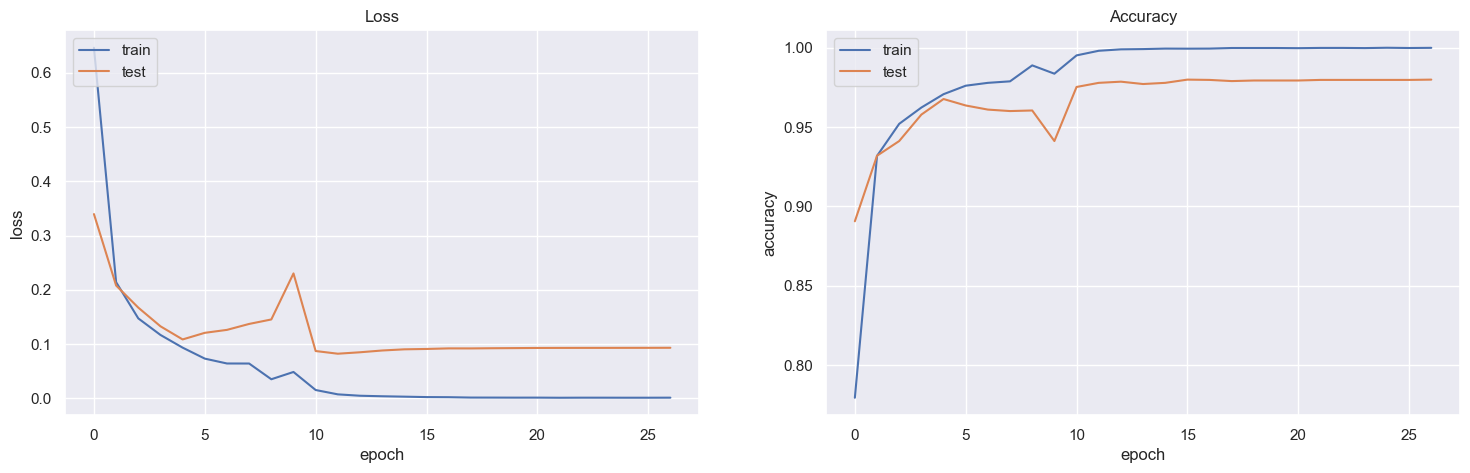

In [55]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.savefig("result.png", dpi=1000)
plt.show()

#plt.savefig("result.png", dpi=1000)

In [40]:
loss, accuracy = model.evaluate(test_set, verbose=1)

22/22 [==============================] - 31s 1s/step - loss: 0.0661 - accuracy: 0.9852


In [41]:
test_set.reset()

In [42]:
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2700/2700 [==============================] - 1s 225us/step


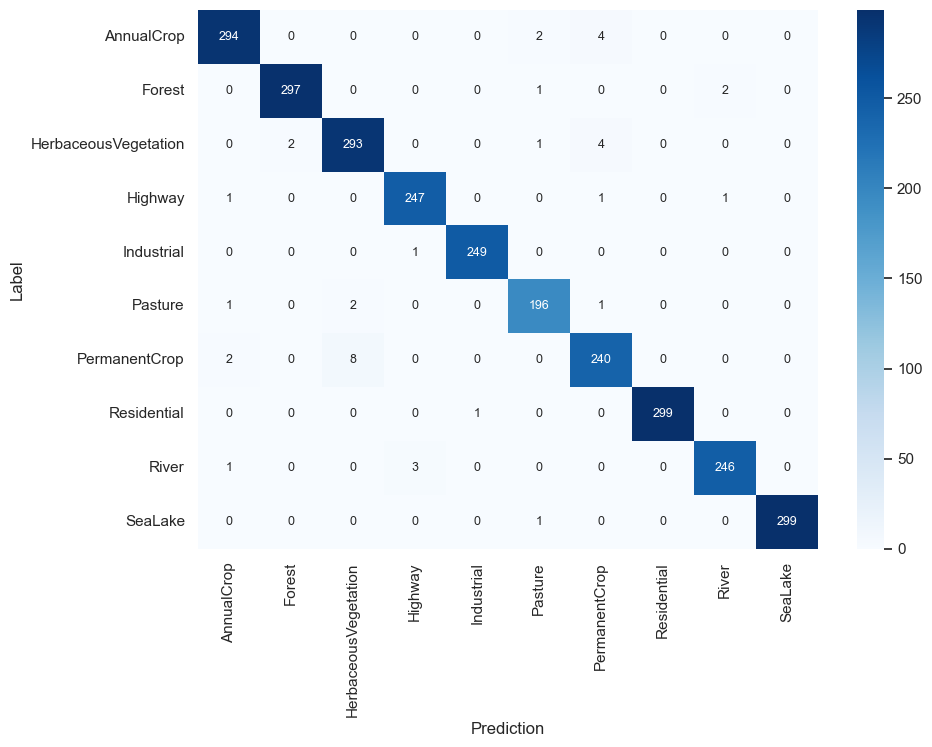

<Figure size 640x480 with 0 Axes>

In [52]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.show()

plt.savefig("CM.png", dpi=1000)

In [44]:
results_df = pd.DataFrame(
    {
        "label": test_set.labels, 
        "prediction": predicted_class_ids, 
        "path": test_set.filepaths
    }
)

# Plot wrong predictions

In [45]:
mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")

40 wrong predictions out of 2700


In [46]:
mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

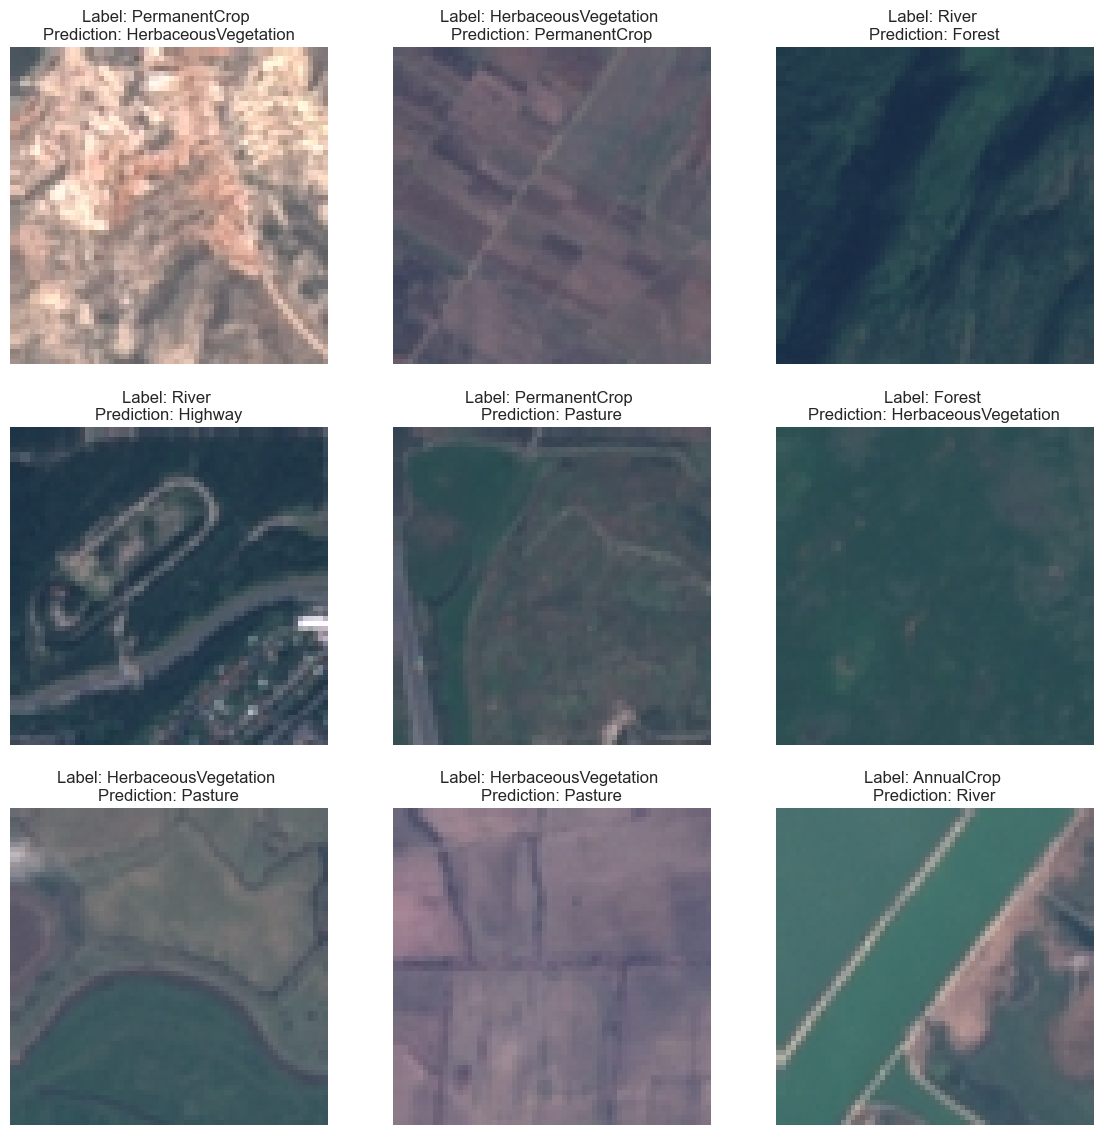

In [53]:
figure_size = (14, 14)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

plt.savefig("wrongs.png", dpi=1000)

# Plot Correct Predictions

In [48]:
# Filter out correct predictions
correct_predictions = results_df[results_df["label"] == results_df["prediction"]]

print(f"{len(correct_predictions)} correct predictions out of {len(results_df)}")

correctly_predicted_labels = (class_name_list[pred] for pred in correct_predictions["prediction"])
correct_labels = (class_name_list[label] for label in correct_predictions["label"])
correct_images = (image.imread(path) for path in correct_predictions["path"])


2660 correct predictions out of 2700


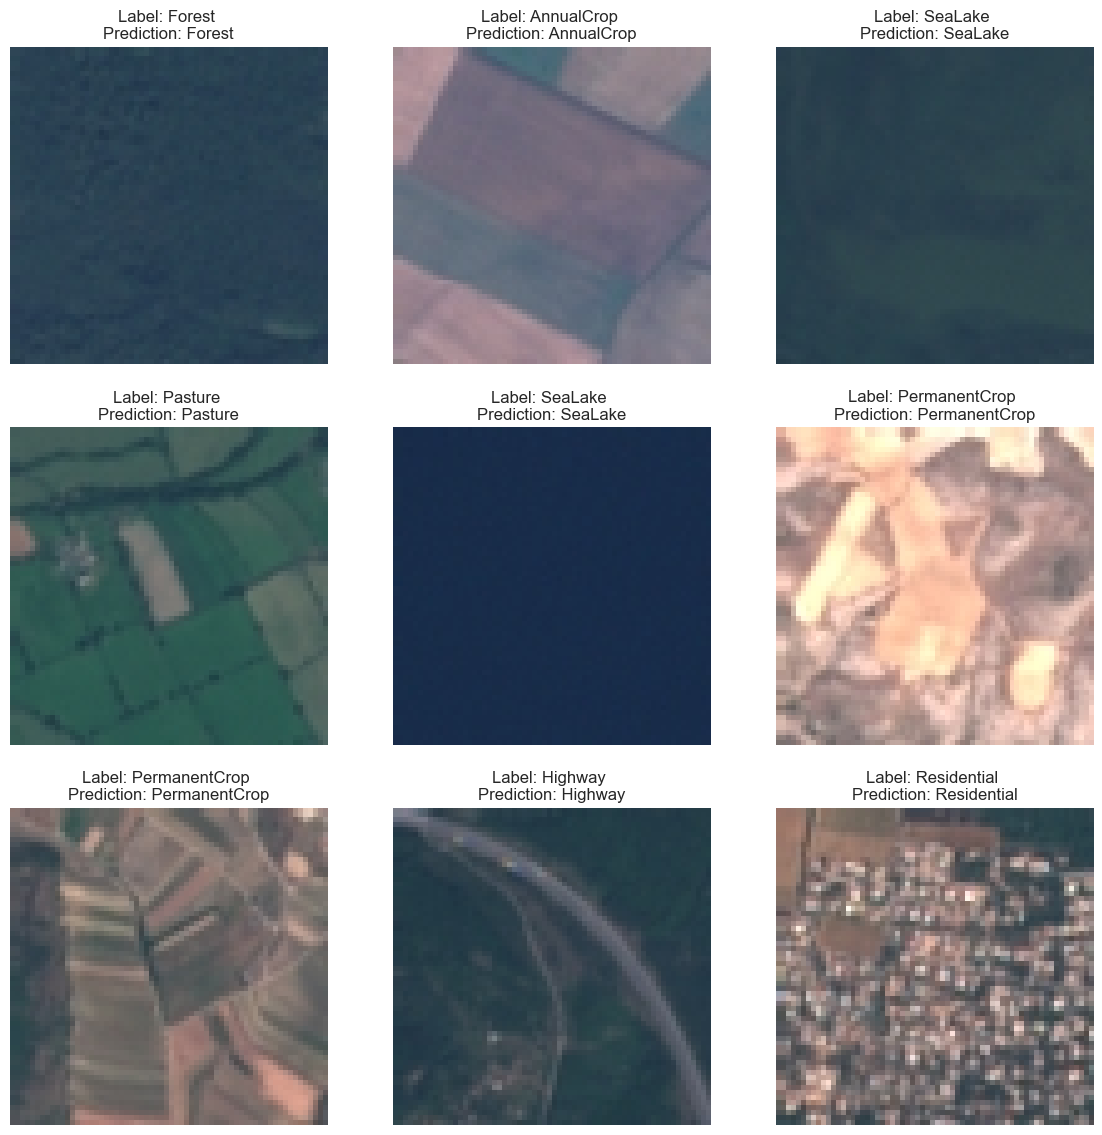

In [56]:
figure_size = (14, 14)
plt.figure(figsize=figure_size)

for index in range(figure_height * figure_width):
    label = next(correctly_predicted_labels)
    prediction = next(correct_labels)
    picture = next(correct_images)

    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")
plt.savefig("Corrects.png", dpi=1000)
plt.show()
